<a href="https://colab.research.google.com/github/sbooeshaghi/SBA-PPP-Loan-Data/blob/master/notebooks/jobs_retained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time
!git clone https://github.com/sbooeshaghi/SBA-PPP-Loan-Data.git

Cloning into 'SBA-PPP-Loan-Data'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 195 (delta 3), reused 5 (delta 2), pack-reused 182
Receiving objects: 100% (195/195), 181.80 MiB | 13.99 MiB/s, done.
Resolving deltas: 100% (109/109), done.
Checking out files: 100% (120/120), done.
CPU times: user 134 ms, sys: 23.9 ms, total: 158 ms
Wall time: 24.2 s


In [2]:
!unzip /content/SBA-PPP-Loan-Data/over_150k/foia_150k_plus.csv.zip

Archive:  /content/SBA-PPP-Loan-Data/over_150k/foia_150k_plus.csv.zip
  inflating: foia_150k_plus.csv      


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def nd(arr):
  return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

# Load data > $150k 

In [4]:
df = pd.read_csv("/content/foia_150k_plus.csv")

In [5]:
df.head()

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD
0,a $5-10 million,"ARCTIC SLOPE NATIVE ASSOCIATION, LTD.",7000 Uula St,BARROW,AK,99723.0,813920.0,Non-Profit Organization,Unanswered,Unanswered,Unanswered,Y,295.0,04/14/2020,"National Cooperative Bank, National Association",AK - 00
1,a $5-10 million,CRUZ CONSTRUCTION INC,7000 East Palmer Wasilla Hwy,PALMER,AK,99645.0,238190.0,Subchapter S Corporation,Unanswered,Unanswered,Unanswered,NaN,215.0,04/15/2020,First National Bank Alaska,AK - 00
2,a $5-10 million,"I. C. E. SERVICES, INC",2606 C Street,ANCHORAGE,AK,99503.0,722310.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,367.0,04/11/2020,KeyBank National Association,AK - 00
3,a $5-10 million,KATMAI HEALTH SERVICES LLC,"11001 O'MALLEY CENTRE DRIVE, SUITE 204",ANCHORAGE,AK,99515.0,621111.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,0.0,04/29/2020,Truist Bank d/b/a Branch Banking & Trust Co,AK - 00
4,a $5-10 million,MATANUSKA TELEPHONE ASSOCIATION,1740 S. CHUGACH ST,PALMER,AK,99645.0,517311.0,Cooperative,Unanswered,Unanswered,Unanswered,NaN,267.0,06/10/2020,CoBank ACB,AK - 00


# Make `df` more usable

In [6]:
df.LoanRange.unique()

array(['a $5-10 million', 'b $2-5 million', 'c $1-2 million',
       'd $350,000-1 million', 'e $150,000-350,000'], dtype=object)

In [7]:
loan = {
    "a $5-10 million": {"lower": 5000000, "upper": 10000000},
    "b $2-5 million": {"lower": 2000000, "upper": 4999999},
    "c $1-2 million": {"lower": 1000000, "upper":1999999},
    "d $350,000-1 million": {"lower": 350000, "upper":999999},
    "e $150,000-350,000" : {"lower": 150000, "upper":349999}
}

In [8]:
df['loan_lower'] = df.LoanRange.apply(lambda x: loan[x]["lower"])
df['loan_upper'] = df.LoanRange.apply(lambda x: loan[x]["upper"])

# Many business reported retaining zero jobs even with PPP

In [9]:
print(f'There are {df.JobsRetained.isna().sum():,.0f} out of {df.shape[0]:,.0f} companies that did not report the number of jobs retained')
print(f"There are {(df.JobsRetained==0).sum():,.0f} out of {df.shape[0]:,.0f} companies that reported 0 number of jobs retained")

There are 40,506 out of 661,218 companies that did not report the number of jobs retained
There are 48,922 out of 661,218 companies that reported 0 number of jobs retained


# These are the companies that reported 0 number of jobs retained

In [10]:
df.iloc[np.where(df.JobsRetained.values == 0.0)[0]]

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,loan_lower,loan_upper
3,a $5-10 million,KATMAI HEALTH SERVICES LLC,"11001 O'MALLEY CENTRE DRIVE, SUITE 204",ANCHORAGE,AK,99515.0,621111.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,0.0,04/29/2020,Truist Bank d/b/a Branch Banking & Trust Co,AK - 00,5000000,10000000
9,a $5-10 million,"TYONEK GLOBAL SERVICES, LLC",1689 C ST,ANCHORAGE,AK,99501.0,611420.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,0.0,04/30/2020,BBVA USA,AK - 00,5000000,10000000
10,a $5-10 million,"TYONEK WORLDWIDE SERVICES, INC.",1689 C ST,ANCHORAGE,AK,99501.0,488190.0,Subchapter S Corporation,Unanswered,Unanswered,Unanswered,NaN,0.0,04/30/2020,BBVA USA,AK - 00,5000000,10000000
21,b $2-5 million,ALASKA VILLAGE ELECTRIC,4831 EAGLE STREET,ANCHORAGE,AK,99503.0,221122.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,0.0,05/06/2020,"Wells Fargo Bank, National Association",AK - 00,2000000,4999999
66,b $2-5 million,"TYONEK MANUFACTURING GROUP, INC.",1689 C ST,ANCHORAGE,AK,99501.0,551112.0,Subchapter S Corporation,Unanswered,Unanswered,Unanswered,NaN,0.0,04/30/2020,BBVA USA,AK - 00,2000000,4999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660402,"e $150,000-350,000",ADVANCED TAX SOLUTIONS LLC,1603 CAPITOL AVE SUITE 310 A254,CHEYENNE,WY,82001.0,541511.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,0.0,05/03/2020,"Wells Fargo Bank, National Association",WY - 00,150000,349999
660560,"e $150,000-350,000","CPC, P.C.",3740 E. Lincolnway,CHEYENNE,WY,82001.0,541940.0,Subchapter S Corporation,White,Male Owned,Unanswered,NaN,0.0,04/05/2020,Live Oak Banking Company,WY - 00,150000,349999
661098,"e $150,000-350,000",TP CORPORATION,1650 BERGER LANE,JACKSON,WY,83001.0,532310.0,Subchapter S Corporation,Unanswered,Unanswered,Unanswered,NaN,0.0,04/08/2020,Rocky Mountain Bank,WY - 00,150000,349999
661131,"e $150,000-350,000",WEEDEN CONSTRUCTION LLC,402 MURPHY GULCH RD,BANNER,WY,82832.0,237310.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,0.0,04/03/2020,Glacier Bank,WY - 00,150000,349999


# It appears that the maximum amount of jobs a business can retain is 500

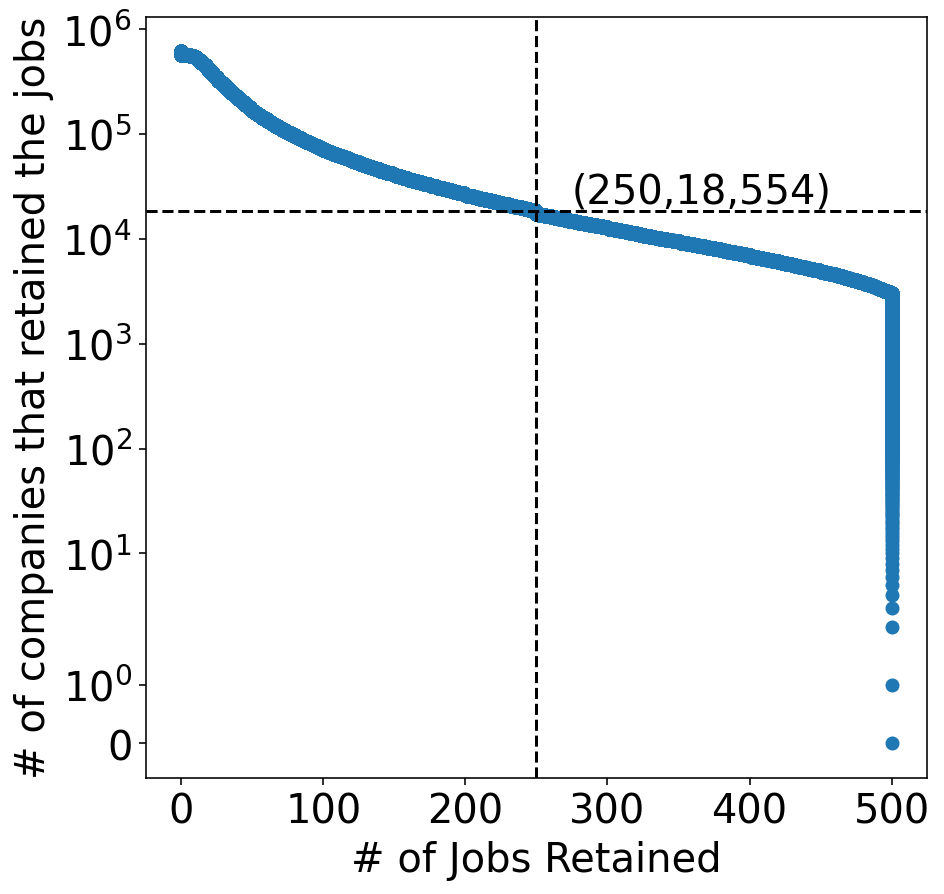

In [11]:
fig, ax = plt.subplots(figsize=(7,7))

m = df.JobsRetained.isna()
njobs = 250
xeps=0.1
yeps=0.2

x = np.sort(df.JobsRetained.values[~m])[::-1]
y = np.arange(len(x))

xl = njobs
yl = y[np.where(x<njobs)[0][0]]

ax.axvline(x=xl, color="k", linestyle="--")
ax.axhline(y=yl, color="k", linestyle="--")

ax.annotate(f"({xl:,.0f},{yl:,.0f})", (xl*(1+xeps), yl*(1+yeps)))

ax.scatter(x, y)


kwd = {"yscale": "symlog",
       "xlabel" : "# of Jobs Retained",
       "ylabel" : "# of companies that retained the jobs"}
ax.set(**kwd)

plt.show()

In [12]:
n = 499
print(f"{(x > n).sum():,.0f} companies retained greater than {n:,.0f} jobs")

3,037 companies retained greater than 499 jobs


In [13]:
print(f"Total number of jobs retained: {x.sum():,.0f}")

Total number of jobs retained: 31,456,513


# Does loan amount correlate with jobs retained?

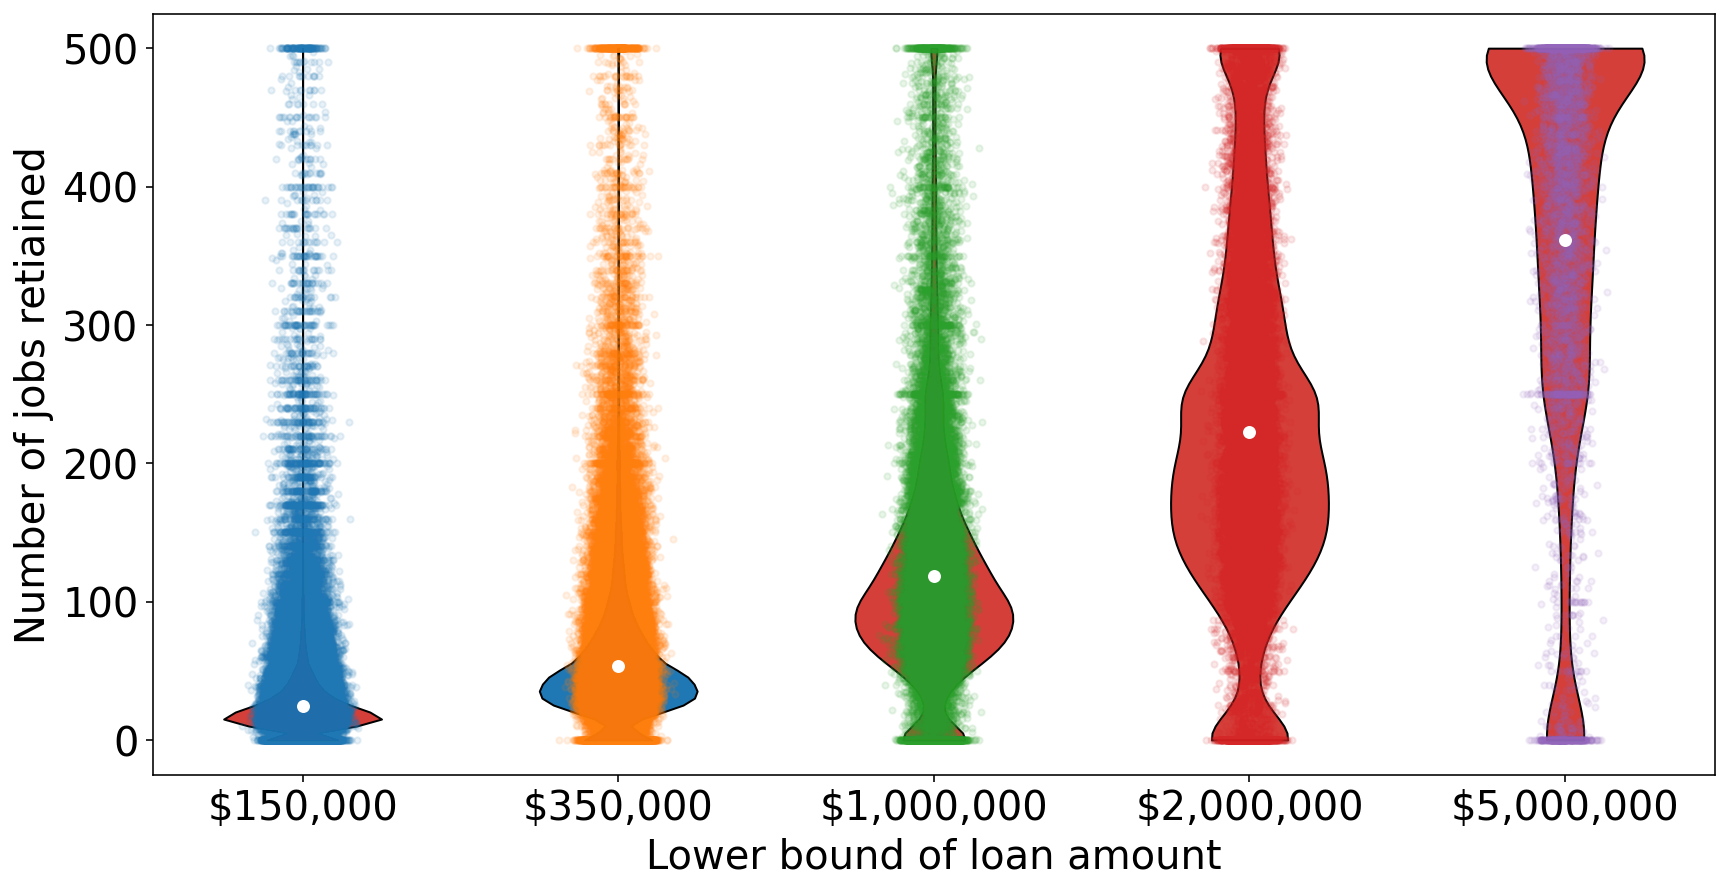

In [14]:
fig, ax = plt.subplots(figsize=(14,7))

alpha=0.1
lower = df.loan_lower.unique()[::-1]

labels = [f"${n:,.0f}" for n in lower]
lidx = np.arange(len(labels)) + 1


x = []
for l in lower:
  x.append(df.query(f"loan_lower == {l}")[df.query(f"loan_lower == {l}")["JobsRetained"].notna()]["JobsRetained"].values)

parts = ax.violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('#D43F3A')
    if pcidx==1: pc.set_facecolor('#1f77b4')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

    
mean = [np.mean(i) for i in x]
ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)

######## Add some random "jitter" to the x-axis
xx = [lval + np.random.normal(1, 0.04, size=len(d))-1 for d, lval in zip(x, lidx)]

for vals, xvals in zip(xx, x):
  ax.scatter(vals, xvals, alpha=alpha, s=10)

ax.set_xticks(lidx)
ax.set_xticklabels(labels)
ax.set_xlabel("Lower bound of loan amount")
ax.set_ylabel("Number of jobs retiained")


plt.show()